In [1]:
import leapfrog as lf
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn import linear_model
from sklearn.svm import l1_min_c
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Number of samples
n = 10000
# Number of features
p = 100
# Generate features X and labels y
X, y = make_classification(n_samples=n, n_features=p, random_state=np.random.RandomState(0))

/home/pbenner/.local/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


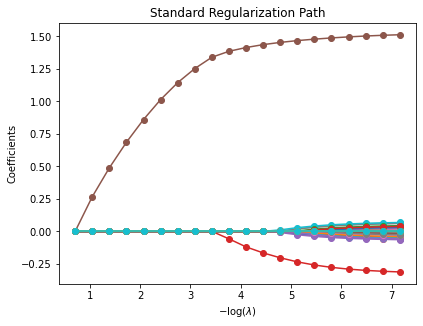

In [36]:
# Use standard logistic regression model from scikit-learn
clf = linear_model.LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-8,
    max_iter=int(1e3),
    warm_start=True)

# Define regularization strengths
cs = l1_min_c(X, y, loss="log") * np.logspace(0, 2.8, 20)

# Loop over regularization strengths and fit model
coefs_reg_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_reg_.append(clf.coef_.ravel().copy())

# Plot regularization path, i.e. coefficients as a function of
# regularization strength
plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.plot(-np.log(1/(n*cs)), np.array(coefs_reg_), marker="o")
plt.xlabel(r"$-\log(\lambda)$")
plt.ylabel("Coefficients")
plt.title("Standard Regularization Path")
plt.axis("tight")
plt.show()


In [12]:
# Definition of a simple logistic regression model, where
# the weights are subject to leapfrog regularization
class LogisticModel(torch.nn.Module):
    def __init__(self, p, q, weight_decay=None):
        super(LogisticModel, self).__init__()
        # The Leapfrog linear layer is identical to the Torch
        # linear layer, except that the weights are subject to
        # leapfrog regularization
        self.linear = lf.Linear(p, 1, q, weight_decay=weight_decay)

    def forward(self, x):
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x

In [20]:
# Specify a list of the number of features we want to estimate
q = [0,1,2,60]

# Define a simple logistic regression model
model = LogisticModel(X.shape[1], q)

# Logistic regression models are trained using the binary cross-entropy
loss_function = torch.nn.BCELoss()
# We use a standard optimizer such as Adam...
optimizer     = torch.optim.Adam(model.parameters(), lr=0.05)
# and augment it with a Leapfrog optimizer that performs the
# regularization steps
optimizer     = lf.Optimizer(optimizer, tolerance=1e-8)
# A maximum of max_epochs is used for training
max_epochs    = 500
# Define the training set and data loader for training, with
# a batch size equal to the full training set (i.e. do not use
# stochastic gradient descent, because the data set and model
# are fairly small)
trainloader   = DataLoader(
  TensorDataset(torch.Tensor(X), torch.Tensor(y)),
  batch_size=int(X.shape[0]),
  shuffle=False,
  num_workers=1)

# Record the regularization strength lambda
l_     = []
# Record the loss
loss_  = []
# Record the coefficients of the logistic regression
coefs_ = []
while True:
  # Do a maximum of max_epochs iterations over the training set
  for _epoch in range(0, max_epochs):
    # Loop over the training set
    for i, data in enumerate(trainloader, 0):
      # Get X (inputs) and y (targets)
      inputs, targets = data
      # Reset gradient
      optimizer.zero_grad()
      # Evaluate model
      outputs = torch.flatten(model(inputs))
      # Compute loss
      loss = loss_function(outputs, targets)
      # Backpropagate gradient
      loss.backward()
      # Perform one gradient descent step
      optimizer.step()
      # Record loss
      loss_.append(loss.item())

      # print(f'Loss: {loss.item()}')

    # Check if optimizer converged (only possible of no
    # stochastic gradient descent is used), or if the
    # maximum number of epochs is reached
    if optimizer.converged(loss.item()) or _epoch == max_epochs-1:
      # Record lambda (weight decay)
      weight_decay = optimizer.get_weight_decay()
      # Each layer and output node has its own weight decay parameter. We
      # have only one layer and output node.
      l_.append(weight_decay[0][0].item())
      # Record coefficients (weights) from the linear layer
      coefs_.append(list(model.parameters())[0][0].detach().numpy().copy())
      break

  print(f'Training process has finished for target q={optimizer.get_q()[0]}.')
  # Select the next q (number of features) for optimization
  if optimizer.next_target():
    # There are no more targets, exit loop
    break


Training process has finished for target q=0.
Training process has finished for target q=1.
Training process has finished for target q=2.
Training process has finished for target q=60.


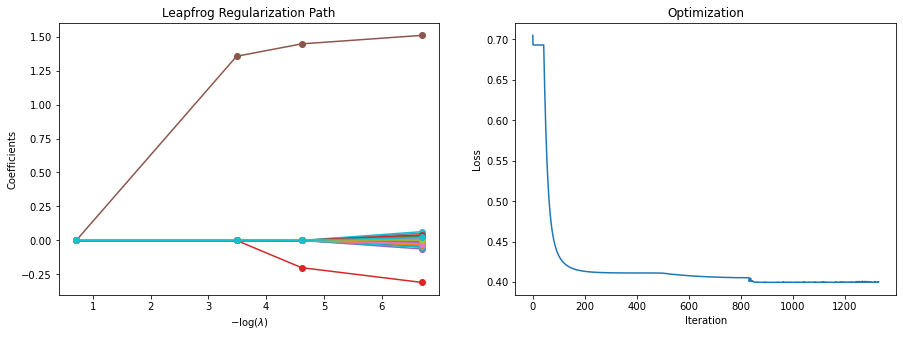

In [34]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(-np.log(l_), np.array(coefs_), marker="o")
ax1.set_xlabel(r"$-\log(\lambda)$")
ax1.set_ylabel("Coefficients")
ax1.set_title("Leapfrog Regularization Path")
ax1.axis("tight")
ax2.plot(np.array(loss_), marker="")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax2.set_title("Optimization")
ax2.axis("tight")
plt.show()